In [1]:
import pickle
import torch.utils.data
import torch
from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd

load_path = './data/cartpole2/sa_ppo_gate_v1'

/home/sgillen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sgillen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sgillen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sgillen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

Logging to /tmp/openai-2019-09-06-19-11-55-634730


/home/sgillen/miniconda3/envs/baselines/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'seagul.nn.Categorical_MLP' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


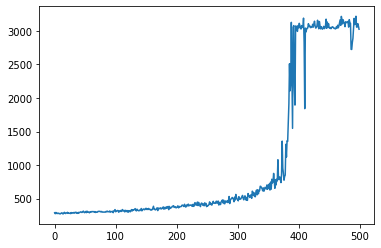

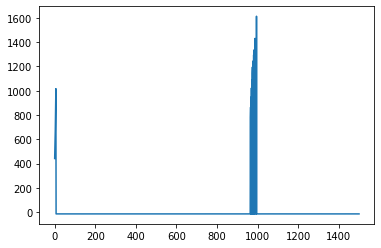

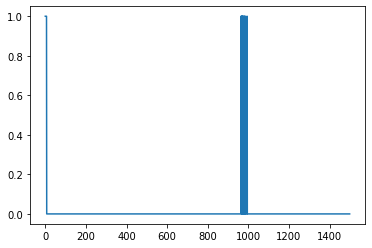

In [2]:
model, env, args, ws = load_workspace(load_path)
plt.plot(ws['avg_reward_hist'])
print
plt.figure()
plt.plot(np.array(ws['ep_action_tensor']))
model.action_var
plt.figure()
plt.plot(np.array(ws['ep_path_tensor']))

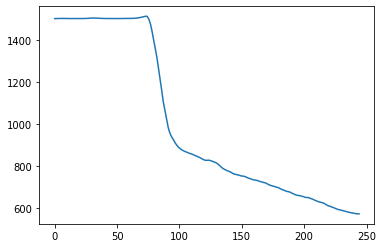

In [11]:
#model, env = load_model(load_path)
data = pd.read_csv(load_path + '/progress.csv')
plt.plot(data['eprewmean'])


1499
[3050.32869659]


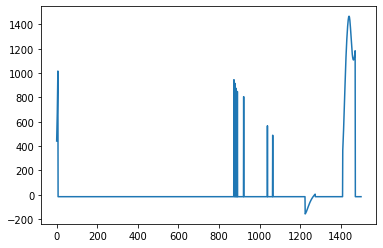

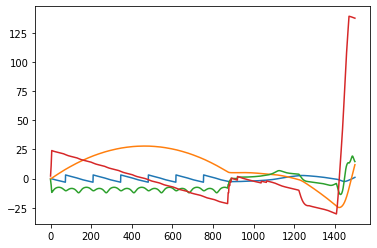

In [3]:
myenv = env
myenv.num_steps=1500

action_hist = np.zeros((myenv.num_steps, myenv.action_space.shape[0]))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))

obs = env.reset()
model.hyst_state = 0

for i in range(myenv.num_steps):
        actions, _, _, _ = model.step(obs)
        #actions = np.zeros(1)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        #env.render()
        if done:
            break

plt.plot(action_hist)
plt.figure()
plt.plot(state_hist)
print(i)
print(sum(reward_hist))

In [5]:
actions, _, _, _ = model.step(obs)
obs, reward, done, _ = env.step(actions)        
env.render()
print(reward)

NoSuchDisplayException: Cannot connect to "None"

In [16]:
env.state[0] = np.pi
env.state[1] = 1
env.render()

True

In [62]:
-(np.cos(env.state[0]) + np.cos(env.state[0] + env.state[1]))

2.0

In [42]:
np.cos(env.state[0])

0.9817307073878629

In [43]:
np.cos(env.state[1])

-0.8691494928152651

In [75]:
env.action_space.high

array([200.], dtype=float32)

In [90]:
pprint(list(ws.keys()))

['gate_loss',
 'local_gate',
 'v_loss',
 'local_values',
 'v_epoch',
 'p_loss',
 'r',
 'old_logp',
 'logp',
 'local_adv',
 'local_actions',
 'local_states',
 'p_epoch',
 'training_generator',
 'training_data',
 'p_adv_tensor',
 'p_action_tensor',
 'p_state_tensor',
 'adv',
 'p_adv_list',
 'p_action_list',
 'p_state_list',
 'ep_adv',
 'deltas',
 'value_preds',
 'ep_gate_tensor',
 'ep_path_tensor',
 'ep_disc_rewards',
 'ep_action_tensor',
 'ep_state_tensor',
 'done',
 'reward',
 'state_np',
 'logprob',
 'action',
 'path',
 '_',
 'gate_out',
 't',
 'gate_list',
 'path_list',
 'reward_list',
 'state_list',
 'action_list',
 'state',
 'gate_tensor',
 'path_tensor',
 'action_tensor',
 'state_tensor',
 'disc_rewards_tensor',
 'adv_tensor',
 'traj_count',
 'traj_steps',
 'batch_steps',
 'episode_reward_sum',
 'epoch',
 'avg_reward_hist',
 'device',
 'use_cuda',
 'g_optimizer',
 'v_optimizer',
 'p_optimizer',
 'old_model',
 'num_states',
 'state_var',
 'state_mean',
 'gate_var_lookup',
 'action_

In [37]:
action_hist

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [108]:
model.policy.state_dict()

OrderedDict([('layers.0.weight', tensor([[-0.4568, -0.2397,  0.2494,  0.0867],
                      [-0.0635, -0.1899,  0.1515,  0.4948],
                      [-0.0567,  0.5281,  0.2798,  0.5175],
                      [ 0.0592, -0.2438,  0.3048,  0.4860],
                      [-0.2917,  0.2407,  0.3931,  0.2287],
                      [ 0.1177,  0.5732, -0.1723,  0.1632],
                      [ 0.0086,  0.1765, -0.2787,  0.0839],
                      [-0.4663, -0.4167, -0.1152,  0.3738],
                      [-0.5503,  0.0039, -0.1740,  0.1334],
                      [-0.1177, -0.4615,  0.2264,  0.3558],
                      [ 0.3594, -0.3565, -0.5538, -0.0646],
                      [ 0.4044, -0.3552,  0.4354,  0.2998],
                      [ 0.2905,  0.2427,  0.3163,  0.0915],
                      [ 0.1865,  0.3092,  0.3525,  0.3288],
                      [-0.0112,  0.0666,  0.1494,  0.2296],
                      [ 0.2755, -0.1681,  0.4193, -0.1604],
                     